In [1]:
#import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


<ipython-input-1-99cd6ba15f64>:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#Import the data
vehicles = pd.read_csv("data/vehicles.csv")

It's now time to clean and prepare the data. 

In [3]:
# Count the number of NaN across the different columns, and format as a percent
nan_percent = (vehicles.isna().sum() / len(vehicles) * 100).apply(lambda x: f"{x:.3g}%")
print(nan_percent)

id                  0%
region              0%
price               0%
year            0.282%
manufacturer     4.13%
model            1.24%
condition        40.8%
cylinders        41.6%
fuel            0.706%
odometer         1.03%
title_status     1.93%
transmission    0.599%
VIN              37.7%
drive            30.6%
size             71.8%
type             21.8%
paint_color      30.5%
state               0%
dtype: object


The data above shows the % of each column that is NaN. In order to clean this data I will take the following steps:
1) drop size column, since nearly 3/4 of the data is missing
2) drop VIN column, since there is a high % missing data, and the series number is unlikely to provide helpful prediction without the ability to interpret it
3) drop the cylinders, drive, and type columns. Although this data could potentially be filled in with the rest of the data provided (likely should be s
ecificed by Manufacturer and Model), it's outisde the scope of this project. So for maximization of clean data I am dropping these columns as well. 
4) drop columns paint color and condition, as they have too much missing data. Future work could be done including condition, which I woudl expect to be an extremely strong predictor of price, but dropping it would lose nearly 50% of the rows. 
5)drop ID coluymn, since it doesn't contain any data, and I prefer to use the default index which starts at one
6) remove the rows with missing data in year, manufacturer, model, odometer, title_status, transmission, fuel since they are all likely helpful data, and the cost to the dataset is minimal


In [4]:
vehicles_clean = vehicles.drop(columns=['size','VIN', 'cylinders', 'type', 'drive','condition','paint_color','id'])
vehicles_clean = vehicles_clean.dropna(subset=['year','manufacturer','model','odometer','title_status','transmission','fuel'])

#nan_percent_clean = (vehicles_clean.isna().sum() / len(vehicles_clean) * 100).apply(lambda x: f"{x:.3g}%")
#print(nan_percent_clean)
print(vehicles_clean.info())
print("")
print('Cleaning this data set removed ', len(vehicles)-len(vehicles_clean), ' rows, or ',  "{:.3g}".format((len(vehicles)-len(vehicles_clean))/len(vehicles)*100 ), '% of the total rows')

<class 'pandas.core.frame.DataFrame'>
Index: 389604 entries, 27 to 426879
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        389604 non-null  object 
 1   price         389604 non-null  int64  
 2   year          389604 non-null  float64
 3   manufacturer  389604 non-null  object 
 4   model         389604 non-null  object 
 5   fuel          389604 non-null  object 
 6   odometer      389604 non-null  float64
 7   title_status  389604 non-null  object 
 8   transmission  389604 non-null  object 
 9   state         389604 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 22.3+ MB
None

Cleaning this data set removed  37276  rows, or  8.73 % of the total rows


Now that I have cleaned the data, it is time to further organize the data, by one-hot encoding the cateogircal variables.

Further investigation showed that some of these columns had ery high numbers of unique values. state has 51 unique values, and region has 404,  model has 21860, and manufacturer. All of these contain potentially extremely useful information, and could be useful. In order to minimize the process times, I'm choosing to drop region and model, and keep manufacturer and state. It is worth noting, that a car dealership in a particular state might benefit from dropping data from all other states, and investigating the differences in region. Similarly, a dealership that specializes in a specific manufacturer might drop all other manufactures, and look deeper into the models. 

In [5]:
## dropping valid data due to too many categorical variables
vehicle_clean_one_hot = vehicles_clean.drop(columns=['region', 'model'])

#onehot-encode the remaining categorical rows:
vehicle_clean_one_hot = pd.get_dummies(vehicle_clean_one_hot)

# Identify the non-one-hot encoded columns
non_one_hot_columns = ['price', 'year', 'odometer']

# Mean-center the non-one-hot encoded columns
vehicle_clean_one_hot[non_one_hot_columns] = vehicle_clean_one_hot[non_one_hot_columns].apply(lambda x: x - x.mean())

In [6]:
#seperate data into x and y sets
vehicle_y = vehicle_clean_one_hot['price']
vehicle_X = vehicle_clean_one_hot.drop(columns='price')

#seperate into train and test sets
vehicle_X_train, vehicle_X_test, vehicle_y_train, vehicle_y_test = train_test_split(vehicle_X, vehicle_y, test_size = 0.3, random_state = 42)

Selected Features: Index(['year', 'manufacturer_mercedes-benz', 'state_ca', 'state_co',
       'state_ct', 'state_fl', 'state_ga', 'state_ia', 'state_il', 'state_ma',
       'state_mi', 'state_mn', 'state_nc', 'state_ny', 'state_or', 'state_pa',
       'state_tn', 'state_tx', 'state_va', 'state_wi'],
      dtype='object')


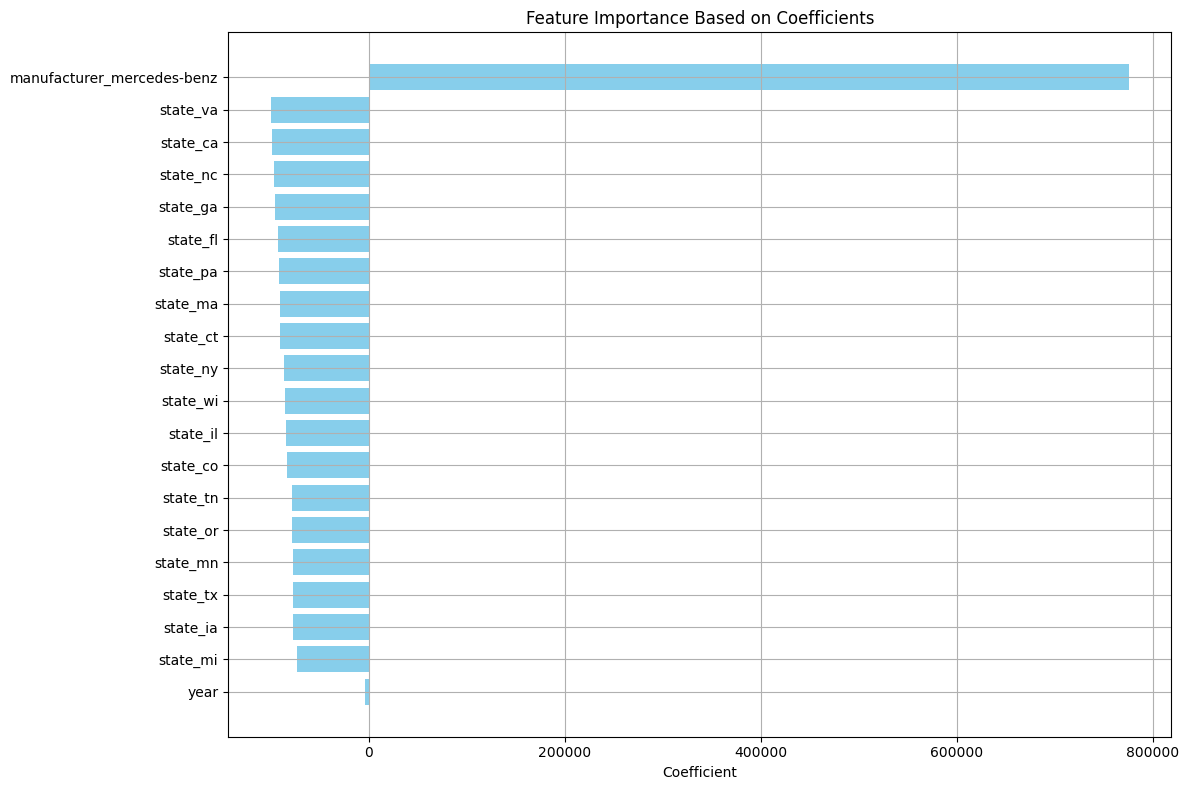

In [7]:
selector = ''
Xt = ''
selector = SequentialFeatureSelector(estimator=LinearRegression(),
                                    n_features_to_select=20,
                                    scoring = 'neg_mean_squared_error')
Xt = selector.fit_transform(vehicle_X_train, vehicle_y_train)

selected_features_mask = selector.get_support()
# Get the list of selected feature names
selected_features = vehicle_X_train.columns[selected_features_mask]

print("Selected Features:", selected_features)

model = LinearRegression()
model.fit(vehicle_X_train[selected_features], vehicle_y_train)
coefficients = model.coef_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': coefficients
})

# Sort by absolute value of coefficients for better visualization
importance_df['Absolute Coefficient'] = np.abs(importance_df['Coefficient'])
importance_df = importance_df.sort_values(by='Absolute Coefficient', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.title('Feature Importance Based on Coefficients')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.savefig("images/features_importance")
plt.show()



The interpretation of this, is that the top influences on price are year, and then whether the manufacturer is mercedes-benz and whether the state is either CA or VA. This intuitively makes sense, as mercedez-benz is a luxury brand, and CA and VA are high cost of living states. However, it doesn't give us much information as a prospective dealership attempting to predict price.

*** Approach 2***

Since there is so much data, I am going to prepare the data for a very different approach

In [8]:
vehicles_ca = vehicles[vehicles['state'] == 'ca']

vehicles_num = vehicles_ca.drop(columns=['size','VIN', 'drive','paint_color','id','transmission','fuel','region','manufacturer','model','state'])
vehicles_num = vehicles_num.dropna(subset=['year','cylinders','odometer','condition','type','title_status'])

print('Cleaning this data set removed ', len(vehicles)-len(vehicles_num), ' rows, or ',  "{:.3g}".format((len(vehicles)-len(vehicles_num))/len(vehicles)*100 ), '% of the total rows')

#seperate data into x and y sets
vehicle_y = vehicles_num['price']
vehicle_X = vehicles_num.drop(columns='price')
vehicle_X_train, vehicle_X_test, vehicle_y_train, vehicle_y_test = train_test_split(vehicle_X, vehicle_y, test_size = 0.3, random_state = 42)


Cleaning this data set removed  407812  rows, or  95.5 % of the total rows


In [9]:
# step 1: differentiate categorical and numerical features
categorical_features = ['condition', 'cylinders','title_status','type']  # categorical feature names for one-hot encoding
numerical_features = ['year','odometer']  # numerical feature names for standardization




In [12]:
# prepare pre-processoring to encode one-hot the categorical features, and scalte the numerical features. 
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

# Step 3: Create a pipeline with preprocessing and Lasso regression
lasso_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso(random_state=42))
])

# Step 4: Define the parameter grid for GridSearchCV
param_grid = {'lasso__alpha': [1, 10, 100,1000]}
lasso_grid_search = GridSearchCV(lasso_pipe, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Step 5: Fit the GridSearchCV on the training data
lasso_grid_search.fit(vehicle_X_train, vehicle_y_train)

# Step 6: Evaluate the model on the test data
lasso_best_params = lasso_grid_search.best_params_
lasso_best_model = lasso_grid_search.best_estimator_
y_pred = lasso_best_model.predict(vehicle_X_test)
lasso_mse = mean_squared_error(vehicle_y_test, y_pred)
lasso_r2 = r2_score(vehicle_y_test, y_pred)

print(f"Mean Squared Error: {lasso_mse}")
print(f"R^2 Score: {lasso_r2}")
best_alpha = lasso_best_params['lasso__alpha']
print(f"Best Alpha for Lasso: {best_alpha}")

Mean Squared Error: 215786573932395.12
R^2 Score: -0.0001600810826447585
Best Alpha for Lasso: 10


In [11]:
ridge_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge(random_state=42))
])

param_grid = {
    'ridge__alpha': [0.1, 1, 10, 100, 1000]  # Example values; adjust as needed
}

# Define GridSearchCV
ridge_grid_search = GridSearchCV(ridge_pipe, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

ridge_grid_search.fit(vehicle_X_train, vehicle_y_train)

# Get the best model
ridge_best_model = ridge_grid_search.best_estimator_

# Get the best parameters
ridge_best_params = ridge_grid_search.best_params_

# Predict on the test set
y_pred = ridge_best_model.predict(vehicle_X_test)

# Evaluate the model
mse = mean_squared_error(vehicle_y_test, y_pred)
r2 = r2_score(vehicle_y_test, y_pred)

print(f"Mean Squared Error of Best Ridge Model: {mse}")
print(f"R^2 Score of Best Ridge Model: {r2}")
print(f"Ridge Best Parameters: {ridge_best_params}")


Mean Squared Error of Best Ridge Model: 215786540680561.03
R^2 Score of Best Ridge Model: -0.00015992696204070178
Ridge Best Parameters: {'ridge__alpha': 1}


Ridge Model outperforms the Lasso model, due to having a lower MSE.



In [ ]:
# Extract the preprocessor and Ridge model from the pipeline
preprocessor = ridge_best_model.named_steps['preprocessor']
ridge_model = ridge_best_model.named_steps['ridge']

# Get the transformed feature names from the preprocessor
feature_names = preprocessor.transformers_[0][1].get_feature_names_out(categorical_features)
feature_names = list(feature_names) + numerical_features

# Get the Ridge model coefficients
ridge_coefficients = ridge_model.coef_

# Create a DataFrame to view coefficients alongside feature names
coefficients_df = pd.DataFrame(ridge_coefficients, index=feature_names, columns=['Coefficient'])

print(coefficients_df)

In [ ]:
# Plotting the coefficients
plt.figure(figsize=(12, 8))
plt.barh(coefficients_df.index, coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients from Ridge Regression')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig("images/feature_coefficients")
plt.show()

In [ ]:
results = ridge_grid_search.cv_results_

# Get the alpha values and corresponding mean test scores
alpha_values = results['param_ridge__alpha'].data
mean_test_scores = -results['mean_test_score']

# Get the best model and predict on the test set
ridge_best_model = ridge_grid_search.best_estimator_
y_pred = ridge_best_model.predict(vehicle_X_test)

# Compute MSE for the test set
test_mse = mean_squared_error(vehicle_y_test, y_pred)
print(test_mse)

# Plot MSE vs. Alpha
plt.figure(figsize=(12, 6))
plt.plot(alpha_values, mean_test_scores, marker='o', label='Mean Test MSE')
plt.xscale('log')  # Log scale for alpha
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs. Alpha for Ridge Regression')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("images/mean_squared_error_vs_alpha")
plt.show()

print(f"Mean Squared Error of Best Ridge Model on Test Set: {test_mse:.2f}")